In [1]:
from pathlib import Path
from functools import partial

import torch
from torch.nn.functional import softmax
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import seaborn as sns

from ballchallenge.model import BallChallengeModel
from ballchallenge.accelerometer_dataset import AccelerometerDataset
from ballchallenge.training import run_training

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = Path("../data")
GRID_SIZE = (10, 10)

In [2]:
def flat_labels(labels: torch.Tensor) -> torch.Tensor:
    return labels.flatten(start_dim=1)

def downsample(samples: torch.Tensor, factor: int) -> torch.Tensor:
    return samples[:,:,::factor]

ds = AccelerometerDataset(
    dataset_root=DATASET_ROOT,
    grid_size=GRID_SIZE,
    x_position_range=(0, 2),
    y_position_range=(0, 2),
    label_std=0.3,
    transform_samples=partial(downsample, factor=4),
    transform_labels=flat_labels,
)
ds_train, ds_test = random_split(ds, lengths=[0.75, 0.25])

print("Train Samples:", ds_train[:][0].shape)
print("Test Samples:", ds_test[:][0].shape)

Train Samples: torch.Size([15, 3, 250])
Test Samples: torch.Size([4, 3, 250])


In [3]:
model = BallChallengeModel(total_bits=16, frac_bits=8, signal_length=ds_train[0][0].shape[1], grid_size=GRID_SIZE)

sum(param.numel() for param in model.parameters())

5117

In [4]:
history = run_training(
    model=model,
    ds_train=ds_train,
    ds_test=ds_test,
    batch_size=8,
    epochs=500,
    learning_rate=1e-3,
    device=DEVICE
)

model.eval()
model.to("cpu")

[epoch 1/500] train_loss: 0.2462 ; train_accuracy: 0.0000 ; test_loss: 0.2479 ; test_accuracy: 0.0000
[epoch 2/500] train_loss: 0.2451 ; train_accuracy: 0.0000 ; test_loss: 0.2504 ; test_accuracy: 0.0000
[epoch 3/500] train_loss: 0.2440 ; train_accuracy: 0.0000 ; test_loss: 0.2553 ; test_accuracy: 0.0000
[epoch 4/500] train_loss: 0.2430 ; train_accuracy: 0.0000 ; test_loss: 0.2597 ; test_accuracy: 0.0000
[epoch 5/500] train_loss: 0.2429 ; train_accuracy: 0.0000 ; test_loss: 0.2617 ; test_accuracy: 0.0000
[epoch 6/500] train_loss: 0.2423 ; train_accuracy: 0.0000 ; test_loss: 0.2617 ; test_accuracy: 0.0000
[epoch 7/500] train_loss: 0.2423 ; train_accuracy: 0.0000 ; test_loss: 0.2602 ; test_accuracy: 0.0000
[epoch 8/500] train_loss: 0.2426 ; train_accuracy: 0.0000 ; test_loss: 0.2593 ; test_accuracy: 0.0000
[epoch 9/500] train_loss: 0.2414 ; train_accuracy: 0.0000 ; test_loss: 0.2593 ; test_accuracy: 0.0000
[epoch 10/500] train_loss: 0.2408 ; train_accuracy: 0.0000 ; test_loss: 0.2604 ; t

BallChallengeModel(
  (hardware_model): Sequential(
    (0): BatchNormedConv1d(
      (_conv1d): Conv1d(3, 16, kernel_size=(8,), stride=(1,))
      (_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): HardTanh(min_val=-1, max_val=1)
    (2): BatchNormedConv1d(
      (_conv1d): Conv1d(16, 8, kernel_size=(16,), stride=(1,))
      (_batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): HardTanh(min_val=-1, max_val=1)
    (4): BatchNormedConv1d(
      (_conv1d): Conv1d(8, 4, kernel_size=(32,), stride=(1,))
      (_batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): HardTanh(min_val=-1, max_val=1)
    (6): BatchNormedConv1d(
      (_conv1d): Conv1d(4, 2, kernel_size=(64,), stride=(1,))
      (_batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): HardTanh(min_val=-1, max_val=1

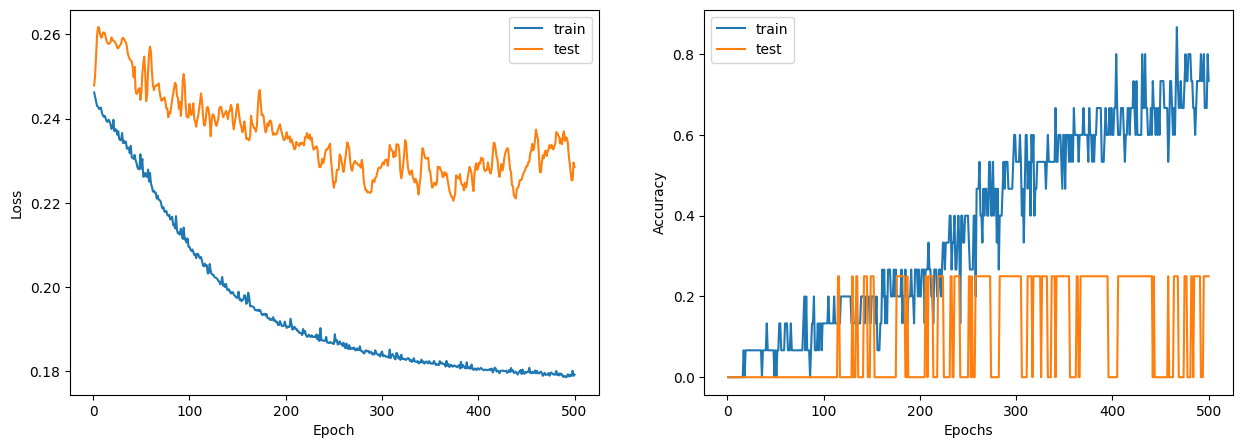

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history.train["epoch"], history.train["loss"], label="train")
axs[0].plot(history.test["epoch"], history.test["loss"], label="test")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(history.train["epoch"], history.train["accuracy"], label="train")
axs[1].plot(history.test["epoch"], history.test["accuracy"], label="test")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

Text(0.5, 1.0, 'Target')

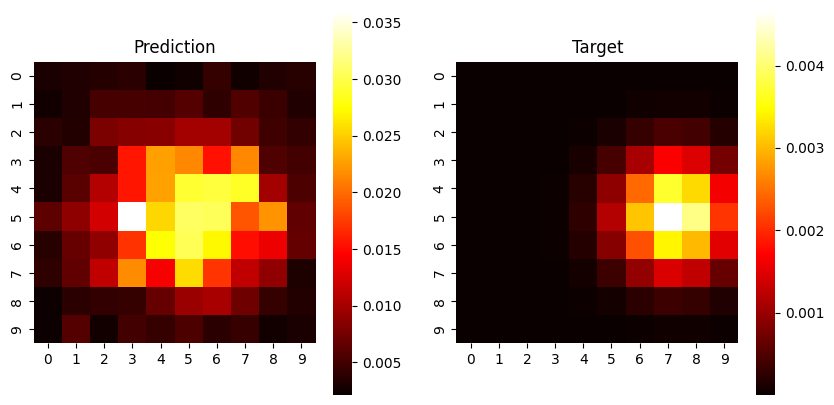

In [8]:
sample_idx = 0

sample, target = ds_test[sample_idx]
prediction = softmax(model(sample).detach(), dim=0).view(*GRID_SIZE[::-1])
target = target.view(*GRID_SIZE[::-1])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.heatmap(prediction, cmap="hot", square=True, ax=axs[0])
axs[0].set_title("Prediction")

sns.heatmap(target, cmap="hot", square=True, ax=axs[1])
axs[1].set_title("Target")

<Axes: >

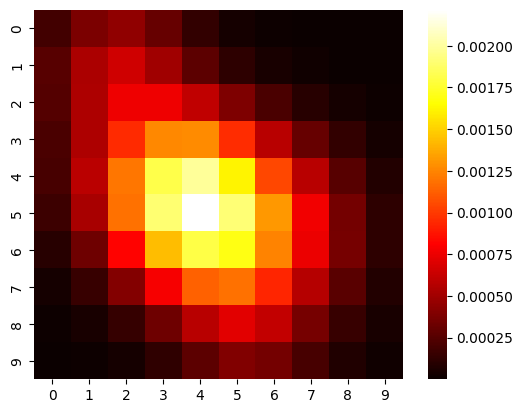

In [7]:
_, labels = ds_train[:]
mean_label = labels.mean(dim=0)
sns.heatmap(mean_label.view(GRID_SIZE), square=True, cmap="hot")